In [18]:
## general imports
import pandas as pd
import numpy as np
import os, sys, gc, warnings
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
warnings.simplefilter("ignore")


In [213]:
# Load clean data
df_final= pd.read_pickle('complete.pkl')
df_final.describe(include= 'all')

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540,590540.000000,581607.0,588975.0,588963,586281.0,...,590528.0,589271.0,589271.0,589271.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,439670,NaN,NaN,NaN,384767,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.282270e+06,0.034990,7.372311e+06,NaN,NaN,9898.734658,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,109.817917,247.600327,162.151230,18.372953,42.073849,28.327173
std,1.704744e+05,0.183755,4.617224e+06,NaN,NaN,4901.170153,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,2269.960449,3979.808105,2792.950928,331.837372,473.217529,381.328247
min,2.987000e+06,0.000000,8.640000e+04,0.250977,NaN,1000.000000,100.0,100.0,NaN,100.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,NaN,6019.000000,214.0,150.0,NaN,166.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,NaN,9678.000000,361.0,150.0,NaN,226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,NaN,14184.000000,512.0,150.0,NaN,226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [75]:
#fillna by -1
cols= df_final.columns
for col in cols:
    df_final[col].fillna(-1,inplace=True)


## Make sure all categorical features are actually of category dtype

In [157]:
# convert categorical features to a format that lightGBM understands (object to category)
#vars =['P_emaildomain', 'addr1', 'addr2','card1','card2', 'card3', 'card5','M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'card4','card6', 'ProductCD']

for c in df_final.columns:
    col_type = df_final[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_final[c] = df_final[c].astype('category')
        
# In the data description the features in cats are reported as categorical data with numbers as values
# convert them back to category

#cats= ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card5']
#for col in cats:
    #df_final[cats]=df_final[cats].astype('category')
    
# check if all categorical features are dtype= category
df_final.describe(include =['category'])

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,590538,588961,588967,496082,319438,319438,319438,309096,240058,421180,244273,244286,244286
unique,5,4,4,59,2,2,2,3,2,2,2,2,2
top,W,visa,debit,gmail.com,T,T,T,M0,F,F,F,F,T
freq,439668,384767,439938,228355,319413,285466,251729,196405,132491,227856,211372,155249,205654


## Model training


In [158]:
# Splitting the dataset into the Training, Validation and Test set
# drop TransactionID since it is an index and doesn't add any value to the model

from sklearn.model_selection import train_test_split, KFold

X = df_final.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis =1 )
y = df_final['isFraud']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y, shuffle = True)

In [159]:
# train_validation_test set shapes

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(472430, 223) (472430,)
(118108, 223) (118108,)


In [160]:
y_train.value_counts()


0    455900
1     16530
Name: isFraud, dtype: int64

In [161]:
y_test.value_counts()

0    113975
1      4133
Name: isFraud, dtype: int64

In [162]:
gc.collect()

350

## Model Training

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.899278
[200]	valid_0's auc: 0.915685
[300]	valid_0's auc: 0.923668
[400]	valid_0's auc: 0.929146
[500]	valid_0's auc: 0.933357
[600]	valid_0's auc: 0.936267
[700]	valid_0's auc: 0.93872
[800]	valid_0's auc: 0.940602
[900]	valid_0's auc: 0.942228
[1000]	valid_0's auc: 0.943602
[1100]	valid_0's auc: 0.944762
[1200]	valid_0's auc: 0.945842
[1300]	valid_0's auc: 0.947007
[1400]	valid_0's auc: 0.947857
[1500]	valid_0's auc: 0.948654
[1600]	valid_0's auc: 0.949273
[1700]	valid_0's auc: 0.949954
[1800]	valid_0's auc: 0.950426
[1900]	valid_0's auc: 0.950989
[2000]	valid_0's auc: 0.951462
Did not meet early stopping. Best iteration is:
[1994]	valid_0's auc: 0.951469
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.895034
[200]	valid_0's auc: 0.912164
[300]	valid_0's auc: 0.920546
[400]	valid_0's auc: 0.925943
[500]	valid_0's auc: 0.930184
[600]	valid_0's auc: 0.933431
[700]	v

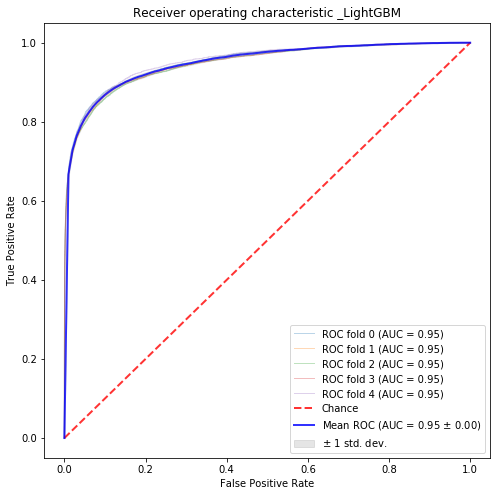

In [216]:
# Run classifier with cross-validation and plot ROC curves
import numpy as np
from scipy import interp
from sklearn.metrics import roc_curve, auc

params = {'max_depth': -1,
              'random_state': 42,
               'learning_rate':0.03,
              'boosting_type': "gbdt",
              'metric':'auc',
              'max_bin': 100,
                'num_leaves': 100,
               'min_data_in_leaf':5000, 
               'objective':'binary',
                'colsample_bytree': 0.5,
              'n_estimators': 2000,
                'feature_fraction': 0.5,
                'is_unbalance ' : True,
                'bagging_fraction':0.5,
              'categorical_feature':['P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'card4','card6', 'ProductCD']

                                            }

cv = StratifiedKFold(n_splits=5, random_state= 42, shuffle= True)
classifier = LGBMClassifier(**params)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 8))


i = 0
for trn_idx, val_idx in cv.split(x_train, y_train):
    x_trn, x_val = x_train.iloc[trn_idx, :], x_train.iloc[val_idx, :]
    y_trn, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]
    model= classifier.fit(x_trn, y_trn, eval_set=[(x_val, y_val)], early_stopping_rounds = 100, verbose = 100)
    probas_ = model.predict_proba(x_val)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_val, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic _LightGBM')
plt.legend(loc="lower right")
plt.show()

## Prediction using parameters from best iteration

In [217]:

#Extracting the best iteration
#best_iteration = model.get_booster ().best_iteration
print ('Best Iteration: {}'.format (model.best_iteration_))
## model fit with the best parameters
#best_model= model.fit(x_train, y_train)

Best Iteration: 2000


In [218]:
# prediction
y_preds = model.predict_proba(x_test, num_iteration= model.best_iteration_)[:, 1]
#convert into binary values

for i in range(0,len(y_test)):
    if y_preds[i]>=.4:       # setting threshold to .5
       y_preds[i]=1
    else:  
       y_preds[i]=0
y_preds[0:5]  # showing first 5 prediction

array([0., 0., 0., 0., 0.])

In [219]:
#Printing the classification report
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_preds))
print(classification_report (y_test, y_preds))
auc = roc_auc_score(y_test,y_preds)
print(f'ROC_AUC: {auc}')

[[113621    354]
 [  1847   2286]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.87      0.55      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.92      0.78      0.83    118108
weighted avg       0.98      0.98      0.98    118108

ROC_AUC: 0.7750015887086676


lgb: f1=0.651 pr_auc=0.717


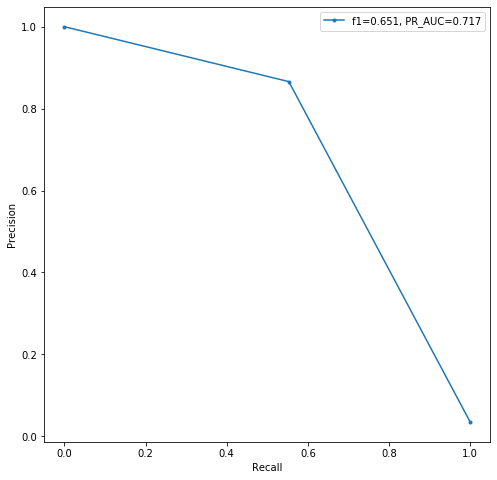

In [243]:
# calculate precision-recall curve
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score, accuracy_score, precision_recall_curve

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, y_preds)
lgb_f1, lgb_auc = f1_score(y_test, y_pred), auc(lgb_recall, lgb_precision)
print('lgb: f1=%.3f pr_auc=%.3f' % (lgb_f1, lgb_auc))
plt.figure(figsize= (8,8))
plt.plot(lgb_recall, lgb_precision, marker='.', label='f1=%.3f, PR_AUC=%.3f' % (lgb_f1, lgb_auc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

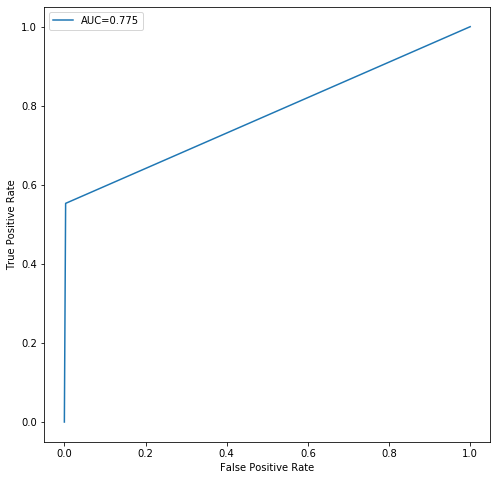

In [244]:
# calculate and print the roc curve
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, y_preds)
lgbm_auc = auc(lgbm_fpr, lgbm_tpr)
plt.figure(figsize= (8,8))
plt.plot(lgbm_fpr, lgbm_tpr, label='AUC=%.3f' % (lgbm_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

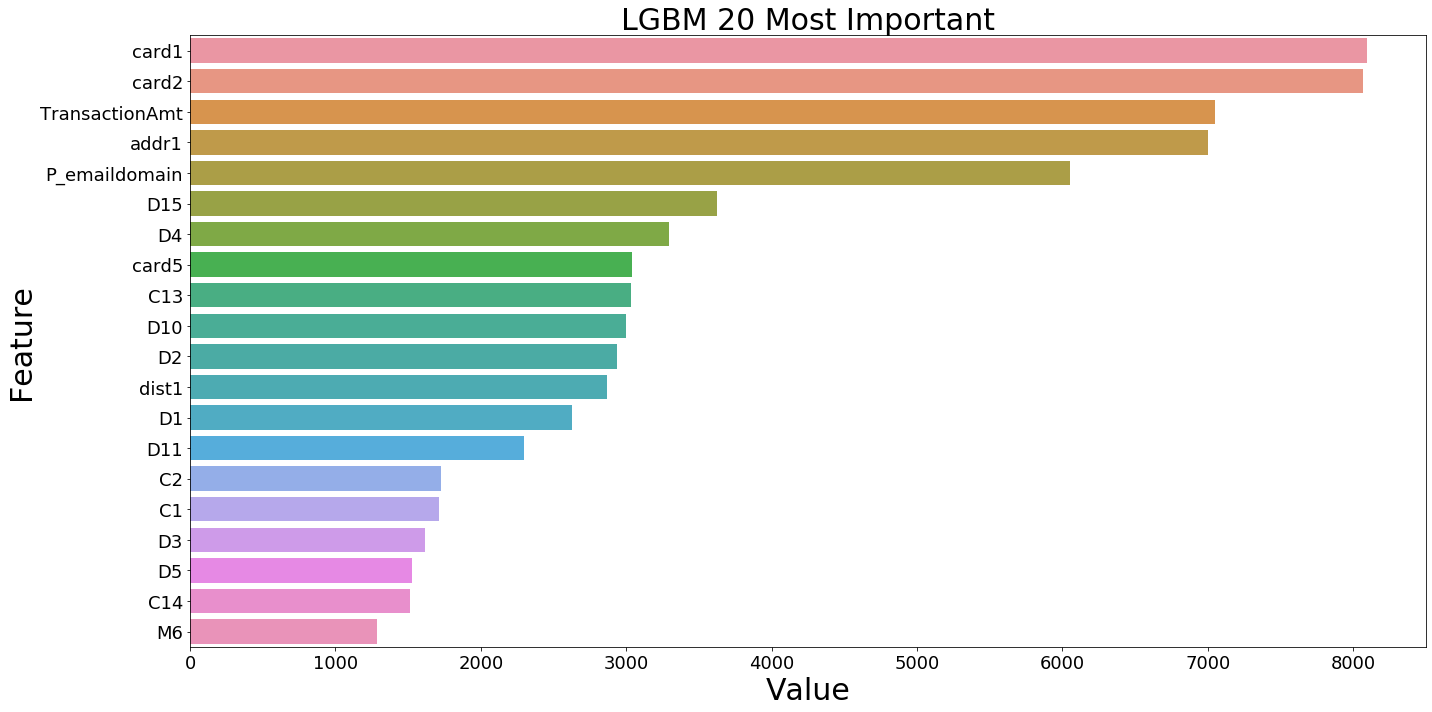

In [245]:
import seaborn as sns
cols = list( x_train.columns )
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
b=sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:20])
b.set_xlabel("Value",fontsize=30)
b.set_ylabel("Feature",fontsize=30)
b.tick_params(labelsize=18)
plt.title('LGBM 20 Most Important', fontsize= 30)
plt.tight_layout()
plt.show()

## Random Undersampling

In [226]:
train= pd.concat([x_train, y_train], axis =1)
train.head(10)
train.isFraud.value_counts()


0    455900
1     16530
Name: isFraud, dtype: int64

In [227]:
# Class count
count_class_0, count_class_1 = train.isFraud.value_counts()

# Divide by class
df_class_0 = train[train['isFraud'] == 0]
df_class_1 = train[train['isFraud'] == 1]

Random under-sampling:
1    16530
0    16530
Name: isFraud, dtype: int64


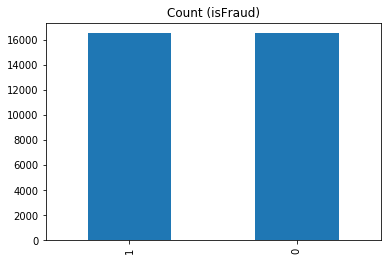

In [228]:
df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under.isFraud.value_counts())

df_train_under.isFraud.value_counts().plot(kind='bar', title='Count (isFraud)');

In [173]:
df_train_under.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33060 entries, 552553 to 443417
Columns: 224 entries, TransactionAmt to isFraud
dtypes: category(13), float16(191), float32(18), int16(1), int8(1)
memory usage: 15.1 MB


In [229]:
# Splitting the dataset into the Training, Validation and Test set
# drop TransactionID since it is an index and doesn't add any value to the model

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit

x_train_u = df_train_under.drop(['isFraud'], axis =1 )
y_train_u = df_train_under['isFraud']


## model training

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.840194
[200]	valid_0's auc: 0.853756
[300]	valid_0's auc: 0.860318
[400]	valid_0's auc: 0.864537
[500]	valid_0's auc: 0.867473
[600]	valid_0's auc: 0.869869
[700]	valid_0's auc: 0.871986
[800]	valid_0's auc: 0.873897
[900]	valid_0's auc: 0.875541
[1000]	valid_0's auc: 0.87699
[1100]	valid_0's auc: 0.878142
[1200]	valid_0's auc: 0.879127
[1300]	valid_0's auc: 0.87997
[1400]	valid_0's auc: 0.880628
[1500]	valid_0's auc: 0.881394
[1600]	valid_0's auc: 0.881986
[1700]	valid_0's auc: 0.882631
[1800]	valid_0's auc: 0.883188
[1900]	valid_0's auc: 0.883739
[2000]	valid_0's auc: 0.884188
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.884195
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.839166
[200]	valid_0's auc: 0.849408
[300]	valid_0's auc: 0.856207
[400]	valid_0's auc: 0.859967
[500]	valid_0's auc: 0.863399
[600]	valid_0's auc: 0.866082
[700]	va

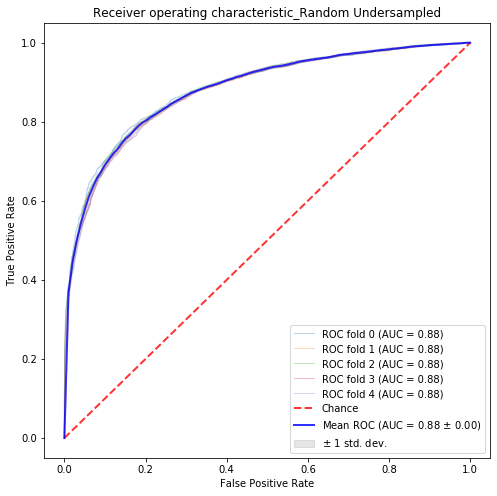

In [233]:
# Run classifier with cross-validation and plot ROC curves
import numpy as np
from scipy import interp
from sklearn.metrics import roc_curve, auc

params_u = {'max_depth': -1,
              'random_state': 42,
               'learning_rate':0.03,
              'boosting_type': "gbdt",
              'metric':'aucpr',
              'max_bin': 255,
                'num_leaves': 500,
               'min_data_in_leaf':100, 
               'objective':'binary',
                'colsample_bytree': 0.8,
              'n_estimators': 2000,
                'feature_fraction': 0.8,
                #'is_unbalance ' : True,
                'bagging_fraction':0.5,
              'categorical_feature':['P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'card4','card6', 'ProductCD']

                                            }
cv = StratifiedKFold(n_splits=5, random_state= 42, shuffle= True)
classifier_u = LGBMClassifier(**params)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 8))


i = 0
for trn_idx, val_idx in cv.split(x_train_u, y_train_u):
    x_trn_u, x_val_u = x_train_u.iloc[trn_idx, :], x_train_u.iloc[val_idx, :]
    y_trn_u, y_val_u = y_train_u.iloc[trn_idx], y_train_u.iloc[val_idx]
    model_u= classifier_u.fit(x_trn_u, y_trn_u, eval_set=[(x_val_u, y_val_u)], early_stopping_rounds = 100, verbose = 100)
    u_probas_ = model_u.predict_proba(x_val_u)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_val_u, u_probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic_Random Undersampled')
plt.legend(loc="lower right")
plt.show()

In [234]:

#Extracting the best iteration
#best_iteration = model.get_booster ().best_iteration
print ('Best Iteration: {}'.format (model_u.best_iteration_))
## model fit with the best parameters
##best_model= clf_opt.fit(x_train, y_train)

Best Iteration: 2000


In [235]:
# prediction
preds_u = model_u.predict_proba(x_test, num_iteration= model_u.best_iteration_)[:, 1]
#convert into binary values

for i in range(0,len(y_test)):
    if preds_u[i]>=.5:       # setting threshold to .5
       preds_u[i]=1
    else:  
       preds_u[i]=0
preds_u[0:5]  # showing first 5 prediction

array([0., 0., 0., 0., 0.])

In [236]:
#Printing the classification report
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, preds_u))
print(classification_report (y_test, preds_u))
auc = roc_auc_score(y_test,preds_u)
print(f'ROC_AUC: {auc}')

[[94583 19392]
 [  904  3229]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113975
           1       0.14      0.78      0.24      4133

    accuracy                           0.83    118108
   macro avg       0.57      0.81      0.57    118108
weighted avg       0.96      0.83      0.88    118108

ROC_AUC: 0.8055650540773927


lgbm: f1=0.241 auc=0.466


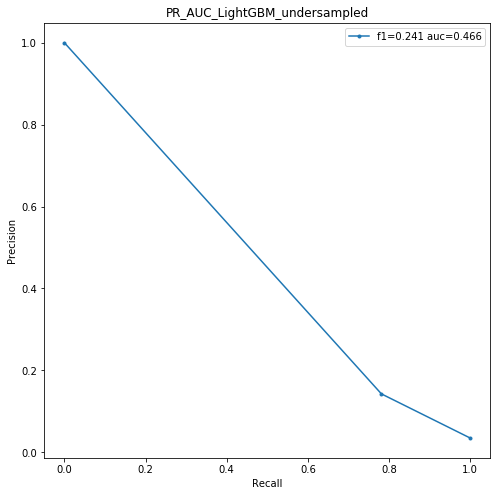

In [239]:
# calculate precision-recall curve
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score, accuracy_score, precision_recall_curve

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, preds_u)
lgb_f1, lgb_auc = f1_score(y_test, preds_u), auc(lgb_recall, lgb_precision)
print('lgbm: f1=%.3f auc=%.3f' % (lgb_f1, lgb_auc))
plt.figure(figsize=(8,8))
plt.plot(lgb_recall, lgb_precision, marker='.', label='f1=%.3f auc=%.3f' % (lgb_f1, lgb_auc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR_AUC_LightGBM_undersampled')
# show the legend
plt.legend()
# show the plot
plt.show()

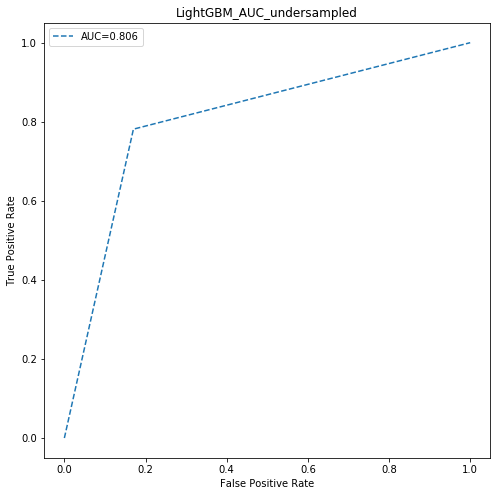

In [242]:
# calculate and print the roc curve
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, preds_u)
lgbm_auc = auc(lgb_fpr, lgb_tpr)
plt.figure(figsize= (8,8))
plt.plot(lgb_fpr, lgb_tpr, linestyle='--', label= 'AUC=%.3f' % (lgbm_auc))
plt.title ('LightGBM_AUC_undersampled')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

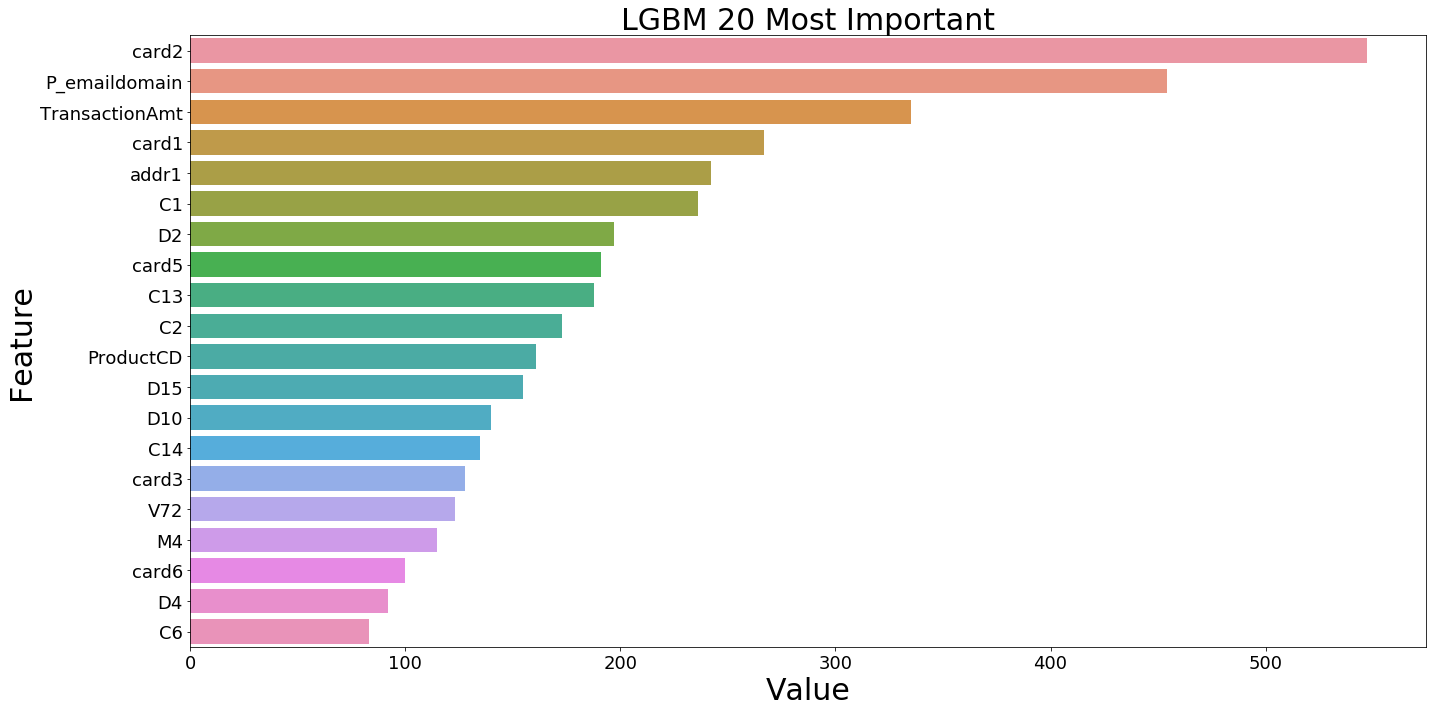

In [246]:
import seaborn as sns
cols = list( x_train.columns )
feature_imp = pd.DataFrame(sorted(zip(model_u.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
b=sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:20])
b.set_xlabel("Value",fontsize=30)
b.set_ylabel("Feature",fontsize=30)
b.tick_params(labelsize=18)
plt.title('LGBM 20 Most Important', fontsize= 30)
plt.tight_layout()
plt.show()

## Bayesian Optimization for Lgbm

In [25]:
#import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer
def tune_lgb(max_depth, learning_rate, num_leaves, feature_fraction, bagging_fraction, colsample_bytree, n_estimators):
    params = {'max_depth': 6,
              'random_state': 42,
               'learning_rate':0.05,
              'boosting_type': "gbdt",
              'metric':'auc',
                'num_leaves': 31,
               'objective':'binary',
                'colsample_bytree': 0.8,
              'n_estimators': 300,
                'feature_fraction': 0.5,
                'bagging_fraction':0.5,
              'categorical_feature':['P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'card4','card6', 'ProductCD']

                                            }

    clff = LGBMClassifier(**params)
    score = cross_val_score(clff, x_train, y_train, cv=5).mean()
    return -score
#Bayesian Optimizer with the specified parameters to tune
lgb_optimizer = BayesianOptimization(tune_lgb, {'num_leaves': (30, 100), 
                                                   'n_estimators': (100, 600),
                                                   'bagging_fraction' : (0.1, 0.9),
                                                   'feature_fraction' : (0.1, 0.9),
                                                   'learning_rate': (0.01, 0.3),
                                                   'colsample_bytree': (0.3,0.9),
                                                   'max_depth':(3,12)})
#performing Bayesian optimization for 5 iterations with 3 steps of random exploration with an #acquisition function of expected improvement
lgb_optimizer.maximize(n_iter=5, init_points=1, acq='ei')

|   iter    |  target   | baggin... | colsam... | featur... | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.9794   |  0.454    |  0.6417   |  0.7939   |  0.1115   |  6.701    |  127.7    |  70.19    |
|  2        | -0.9794   |  0.8946   |  0.5562   |  0.1561   |  0.1203   |  5.015    |  547.5    |  53.64    |
|  3        | -0.9794   |  0.8183   |  0.4116   |  0.1763   |  0.2443   |  9.194    |  598.9    |  99.62    |


In [26]:
#Extracting the best parameters
best_params = lgb_optimizer.max['params']
print(best_params)
#Converting the max_depth and n_estimator values from float to int
best_params['max_depth']= int(best_params['max_depth'])
best_params['num_leaves']= int(best_params['num_leaves'])
best_params['n_estimators']= int(best_params['n_estimators'])


{'bagging_fraction': 0.4539575186148377, 'colsample_bytree': 0.6417311609647954, 'feature_fraction': 0.7938745015620546, 'learning_rate': 0.11151768509533413, 'max_depth': 6.701489217201758, 'n_estimators': 127.66093487568644, 'num_leaves': 70.1914131893001}
